# Случайный лес

В этом практическом задании вы решите задачу регрессии на реальных данных при помощи линейной модели и случайного леса. 

## Цели практической работы

* Научиться применять случайный лес в задаче регрессии.
* Научиться сравнивать качество случайного леса с качеством линейной модели.
* Научиться настраивать гиперпараметры леса.

## Что входит в работу

* Выполнить предобработку данных.
* Обучить линейную регрессию на данных задачи.
* Обучить случайный лес на данных задачи.
* Подобрать гиперпараметры для леса.
* Визуализировать важность признаков у леса.

## Что оценивается

*  Все ячейки заполнены; при запуске ячеек  Python не выдаёт информацию об ошибках.
*  Качество итоговой модели $R^2$ превышает 0,95.


## Что нужно сделать

Постройте модели, предсказывающие стоимость автомобилей по характеристикам.

Признаков у машин много, но в этой работе обойдёмся только числовыми признаками:
*  year — год производства автомобиля;
*  km_driven — пробег;
*  seats — количество посадочных мест;
*  mileage — другая характеристика пробега;
*  engine — мощность двигателя;
*  max_power — мощность автомобиля.

Целевая переменная — selling_price.

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score

train = pd.read_csv("cars_train.csv")
test = pd.read_csv("cars_test.csv")

In [13]:
train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014.0,450000.0,145500.0,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014.0,370000.0,120000.0,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010.0,225000.0,127000.0,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,"Maruti Swift VXI BSIII,2007,130000,120000,Petr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hyundai Xcent 1.2 VTVT E Plus,2017.0,440000.0,45000.0,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


Создайте объекты Xtrain, ytrain, Xtest, ytest. Запишите в них матрицы «объект — признак» и векторы целевой переменной для тренировочного и тестового датасетов.

В тренировочных данных есть автомобили, для которых неизвестна стоимость. Удалите эти автомобили из трейна.

In [16]:
train = train.dropna(subset = ['selling_price'])

In [17]:
X_train = train.drop(columns=['selling_price', 'name','fuel','seller_type','owner','torque','transmission'], axis=1)
y_train = train['selling_price']
X_test = test.drop(columns = ['selling_price', 'name','fuel','seller_type','owner','torque','transmission'] , axis = 1)
y_test = test['selling_price']

Перед обучением моделей обработайте данные.

Обратите внимание, что столбцы mileage, engine и max_power по смыслу числовые. Чтобы превратить их в числовые столбцы, отбросьте единицы измерения и оставьте только числа. В столбцах есть пропущенные значения, их при обработке трогать не нужно.

In [19]:
X_train.head()

,year,km_driven,mileage,engine,max_power,seats
0,2014.0,145500.0,23.4 kmpl,1248 CC,74 bhp,5.0
1,2014.0,120000.0,21.14 kmpl,1498 CC,103.52 bhp,5.0
2,2010.0,127000.0,23.0 kmpl,1396 CC,90 bhp,5.0
4,2017.0,45000.0,20.14 kmpl,1197 CC,81.86 bhp,5.0
6,2001.0,5000.0,16.1 kmpl,796 CC,37 bhp,4.0


In [20]:
replacement_mileage = {' kmpl':'',' km/kg':''}
X_train['mileage'] = X_train['mileage'].replace(replacement_mileage, regex = True).astype(float)
X_test['mileage'] = X_test['mileage'].replace(replacement_mileage, regex = True).astype(float)

replacement_engine = {' CC':''}
X_train['engine'] = X_train['engine'].replace(replacement_engine, regex = True).astype(float)
X_test['engine'] = X_test['engine'].replace(replacement_engine, regex = True).astype(float)

replacement_power = {' bhp':''}
X_train['max_power'] = X_train['max_power'].replace(replacement_power, regex = True).astype(float)
X_test['max_power'] = X_test['max_power'].replace(replacement_power, regex = True).astype(float)

Оставьте в данных только шесть числовых столбцов:

year, km_driven, seats, engine, mileage, max_power

In [22]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1000 non-null   int64  
 1   km_driven  1000 non-null   int64  
 2   mileage    981 non-null    float64
 3   engine     981 non-null    float64
 4   max_power  981 non-null    float64
 5   seats      981 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 47.0 KB


In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6699 entries, 0 to 6997
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       6699 non-null   float64
 1   km_driven  6699 non-null   float64
 2   mileage    6497 non-null   float64
 3   engine     6497 non-null   float64
 4   max_power  6503 non-null   float64
 5   seats      6497 non-null   float64
dtypes: float64(6)
memory usage: 366.4 KB


Теперь заполните пропуски следующим образом:

*    вычислите средние значения по столбцам тренировочной выборки;

*    добавьте в пропуски в тренировочных и тестовых данных вычисленные средние.

In [25]:
mean_mil = X_train['mileage'].mean()
X_train['mileage'] = X_train['mileage'].fillna(mean_mil)
X_test['mileage'] = X_test['mileage'].fillna(mean_mil)

mean_engine = X_train['engine'].mean()
X_train['engine'] = X_train['engine'].fillna(mean_engine)
X_test['engine'] = X_test['engine'].fillna(mean_engine)

mean_max_power = X_train['max_power'].mean()
X_train['max_power'] = X_train['max_power'].fillna(mean_max_power)
X_test['max_power'] = X_test['max_power'].fillna(mean_max_power)

freq_seats = X_train['seats'].mode()[0]
X_train['seats'] = X_train['seats'].fillna(freq_seats)
X_test['seats'] = X_test['seats'].fillna(freq_seats)

Теперь на обработанных тренировочных данных обучите:

*  линейную регрессию,
*  случайный лес с параметрами по умолчанию.

На обработанных тестовых данных сделайте предсказание и вычислите метрику $R^2$. 

In [27]:
lin_reg = LinearRegression()
rfg = RandomForestRegressor() 

lin_reg.fit(X_train, y_train)
rfg.fit(X_train, y_train)

RandomForestRegressor()

In [28]:
pred_lin_reg = lin_reg.predict(X_test)
pred_rfg  = rfg.predict(X_test)
print(f'RandomForest: {r2_score(y_test, pred_rfg)}\nLinearReg: {r2_score(y_test, pred_lin_reg)}')

RandomForest: 0.961550489414821
LinearReg: 0.6481957240589242


Какая модель получилась лучше?

In [30]:
#Случайный лес

Улучшите качество предсказания случайного леса путём подбора гиперпараметров:

*   n_estimators,
*   max_depth,
*   max_features,
*   min_samples_leaf,
*   min_samples_split.

Для подбора гиперпараметров используйте GridSearchCV. Обучайте GridSearchCV по тренировочным данным с разбивкой на три фолда и метрикой $R^2$.

In [44]:
from sklearn.model_selection import GridSearchCV
import numpy as np 
params = {
    'n_estimators':np.arange(1,100,50),
    'max_depth': np.arange(1,20,2),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf':np.arange(1,10,2),
    'min_samples_split':np.arange(1,10,2)
}

grid = GridSearchCV(rfg, params, cv = 3, scoring='r2')
grid.fit( X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
900 fits failed out of a total of 4500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': array([1, 3, 5, 7, 9]),
                         'min_samples_split': array([1, 3, 5, 7, 9]),
                         'n_estimators': array([ 1, 51])},
             scoring='r2')

In [46]:
grid.best_params_

{'max_depth': 15,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 51}

Теперь обучите на тренировочных данных случайный лес с найденными гиперпараметрами. Сделайте предсказание на тестовых данных и оцените его качество ($R^2$).

In [48]:
# Ваш код здесь
rgf = RandomForestRegressor(max_depth=15, max_features=None, min_samples_leaf =3, min_samples_split=7, n_estimators = 51)
rfg.fit(X_train, y_train)
pred_rfg = rfg.predict(X_test)
r2_score(y_test, pred_rfg)

0.9633399671434458

Модель готова. Осталось её проинтерпретировать.

При помощи метода model.feature_importances_ визуализируйте гистограмму важности признаков у случайного леса с настроенными гиперпараметрами.

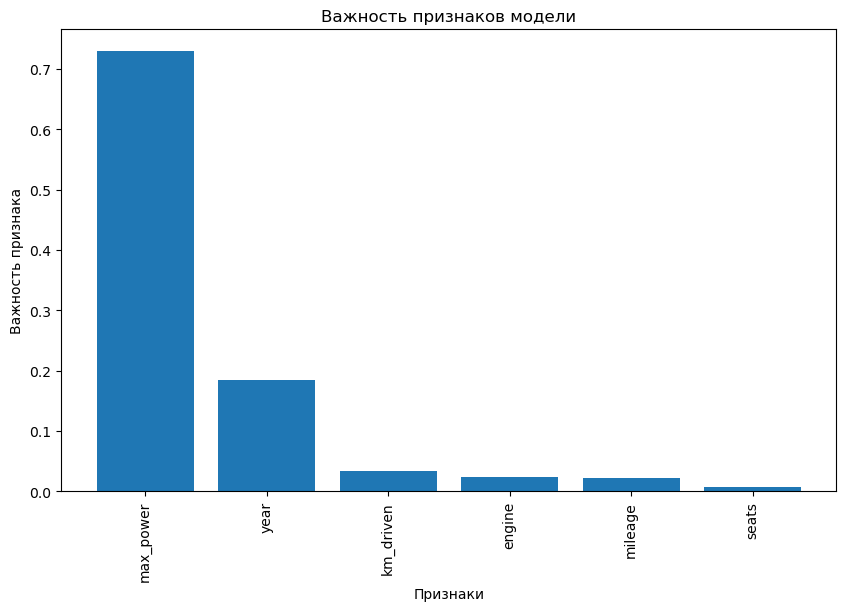

In [72]:
import matplotlib.pyplot as plt

feature_importances = rfg.feature_importances_
feature_name = X_train.columns
indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_name[i] for i in indices]
sorted_importances = feature_importances[indices]
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel("Признаки")
plt.ylabel("Важность признака")
plt.title("Важность признаков модели")
plt.show()